# **Modelo final - Grupo03**

## **Authors**
- César López Mantecón - 100472092
- Manuel Gómez-Plana Rodríguez - 100472310

## **Repositorio**
Esta práctica se ha llevado a cabo en [este repositorio de github](https://github.com/CLopMan/aprendizajeAutomatico-G03)

## Introducción 
En este cuaderno se resolverá un problema similar. Las instancias de energía se han clasificado en "low" o "high" según si su valor es inferior o superior al valor del tercer cuartil. 


In [4]:
import pandas as pd 


raw_data = pd.read_csv("wind_ava.csv.gz", compression='gzip') 
sotavento = raw_data.filter(regex='13$|energy|datetime') # eliminacion de instancias no referentes a Sotavento

Q3 = sotavento["energy"].quantile(0.75)
sotavento.insert(1, "energyTag", ["high" for i in range(len(sotavento))])

def myfunc(v):
    if v < Q3:
        return "low"
    else:
        return "high"
cont = 0
for i, v in enumerate(sotavento["energy"]):
    if v < Q3:
        sotavento.loc[i, "energyTag"] = "low"
        cont += 1
sotavento = sotavento.drop("energy", axis=1)


## Clases desbalanceadas
Si observamos los valores de `energyTag`, la nueva columna del dataframe que indica la clase de cada instancia, podemos ver que las clases están desbalanceadas. 

Número de instancias 'low': 3561
Número de instancias 'high':1187


<Axes: ylabel='count'>

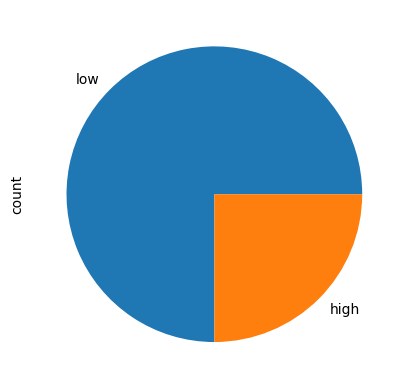

In [5]:
print(f"Número de instancias \'low\': {cont}\nNúmero de instancias \'high\':{len(sotavento) - cont}")

sotavento["energyTag"].value_counts().plot(kind="pie")